# This code computes the loss of signal-to-noise for $f_{NL}$ in a PUMA-like survey when including non-Gaussian covariance

### import packages

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.special import spherical_jn
import scipy.special as sp
from joblib import Parallel, delayed
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
import vegas

%config InlineBackend.figure_format = 'svg' 
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams.update({'font.size': 14})

## Load linear power spectrum

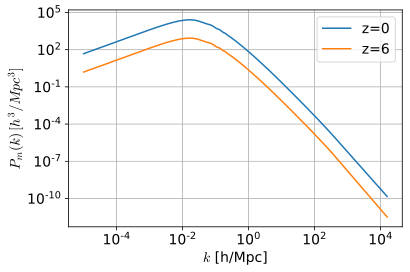

In [82]:
zs = np.linspace(0,6,121)

PLin = np.loadtxt("PLinear2015.dat")
kLin = PLin[:,0]
PLin = PLin[:,1:]
PLinIntz = interp1d(zs,PLin)
PLinIntk = interp1d(kLin,PLin.T)

plt.loglog(kLin,PLin[:,0])
plt.loglog(kLin,PLin[:,-1])
plt.legend(["z=0","z=6"])
plt.xlabel("$k$ [h/Mpc]")
plt.ylabel("$P_m(k) \, [h^3 / Mpc^3]$")
plt.grid()
plt.show()

## Define the cosmology and primordial power spectrum

In [83]:
h = 0.6774
As = 2.142e-9
ns = 0.9667

Omega_m = 0.30749398806757705
Omega_b = 0.048597561544344206
Omega_c = Omega_m - Omega_b
Omega_k = 0.
Omega_L = 1. - Omega_m
H0 = 100 * h
Hofz = lambda z: H0 * np.sqrt(Omega_m * (1+z)**3 + Omega_k * (1+z) + Omega_L)

A = 2*np.pi*np.pi*As
kpivot = 0.05
pfactor = A*kpivot**(1.-ns)

def Pprim(k):
    return np.power(k,ns-4.)*pfactor

### Choose the redshift binning and compute bin volumes, $k_{min}$ and $k_{NL}$: $$ V_s(z) = \frac{4\pi}{3}(r(z+\Delta z)^3 - r(z-\Delta z)^3) $$ $$ L(z) = V_s(z)^{1/3}$$ $$ k_{min}(z) = \frac{2\pi}{L(z)}$$ $$ k_{max}(z) = 0.75k_{NL}(z) = 0.75 k_{NL}(z) = 0.75 \left[ \frac{1}{6\pi^2}\int_0^\infty dk \; P_\delta^L(k,z) \right]^{-1/2}$$

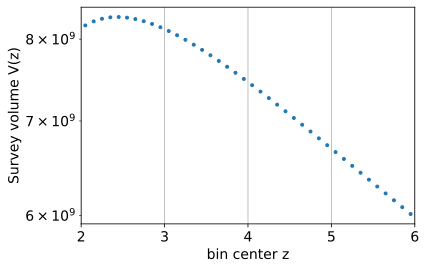

In [22]:
rs = np.genfromtxt("comovingD-0-6.dat") #in units of Mpc/h

bin_start = 41; bin_skip = 2 #this is a bin size of \delta z = 0.1
# bin_start = 42; bin_skip = 4 #this is a bin size of \delta z = 0.2
# bin_start = 44; bin_skip = 8 #this is a bin size of \delta z = 0.4
# bin_start = 48; bin_skip = 16 #this is a bin size of \delta z = 0.8
# bin_start = 60; bin_skip=40

zbins = zs[bin_start::bin_skip]
nbins = len(zbins)
rbins = np.diff(rs[bin_start-bin_skip//2::bin_skip]) #the 1D size of the bin in units of Mpc/h
rtobins = rs[bin_start::bin_skip] # the distance to the bin in units of Mpc/h
Vbins = 4/3*np.pi * (np.diff(rs[bin_start-bin_skip//2::bin_skip]**3)) 
kmins = 2*np.pi / (Vbins)**(1/3) # largest scale accessible in units of (h/Mpc)
Vbins *= 0.5# factor of 0.5 is because PUMA assumes 0.5 sky coverage

plt.semilogy(zbins,Vbins,".")
plt.xlabel('bin center z')
plt.ylabel("Survey volume V(z)")
plt.xlim(2,6)
plt.grid()
plt.show()

kNLs = (integrate.simpson(PLin[:,bin_start::bin_skip],kLin,axis=0)/6/np.pi**2)**-.5
kmaxs = 0.75*kNLs

### To turn the primordial bispectrum into a matter bispectrum we also need the transfer function: $$B^{pnG}_\delta(z;k_1,k_2,k_3) = \left(\prod_{i=1}^3 \mathcal{M}(k_i,z) \right) B_\zeta(k_1,k_2,k_3)$$

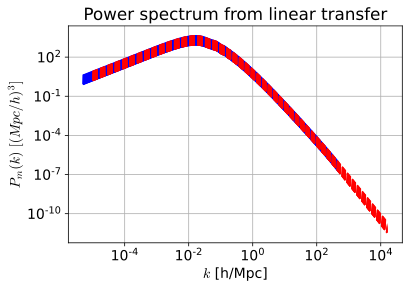

In [23]:
transfer_data = np.genfromtxt("LinearTransfer2015.dat")
k_transfer = transfer_data[:,0]
Tc0 = transfer_data[:,1]
Tc = transfer_data[:,1+bin_start::bin_skip] #take transferfunction in bin centers
Pprimk = Pprim(k_transfer*h)

plt.loglog(k_transfer,(h**3 * Pprimk[:,np.newaxis] * Tc**2),"b")
plt.loglog(kLin,PLin[:,bin_start::bin_skip],"--r")
plt.xlabel("$k$ [h/Mpc]")
plt.ylabel("$P_m(k)$ $[(Mpc/h)^3]$")
plt.title("Power spectrum from linear transfer")
plt.grid()
plt.show()

## Define a bunch of PUMA specs and compute the thermal noise

In [24]:
## PUMA specs
Ddish = 6. #meters #dish size
eta_a = 0.7 #unitless #efficiency factor
Deff = np.sqrt(eta_a * Ddish**2) #meters #effective dish size
Ae = np.pi * (Deff/2)**2 #meters^2 #effective collecting area # pi r^2 area
lambda_z = 21.10611405413e-2 * (1+zbins) #meters #redshifted 21cm wavelength
Npol = 2. #unitless #number of polarizations per feed
ttot = 5 * 365 * 24 * 60 * 60 / 4 #seconds #total observation time
fsky = 0.5 #unitless #fraction of the sky
Sarea = 4*np.pi * fsky #steradians #area of sky
theta_FOV = lambda_z / Deff #unitless #field of view
Ns_dish = 256 #number of dishes per side
Ns_dish = 362.03867196751236
n0 = (Ns_dish/Ddish)**2
L_dish = Ns_dish * Ddish # meters
clight = 299792.458 #km/s #speed of light
fbins = clight*1e3 / lambda_z
D_baseline = 700 #meters

eta_s = 0.9
eta_c = 0.9

Tampl = 50 #Kelvin
Tground = 300 #Kelvin
Tsky = (fbins/400e6)**(-2.75) * 25 + 2.7 #Kelvin
Tscope = Tampl/eta_s/eta_c + (1-eta_s)/eta_s * Tground
Tinst = (Tscope +  Tsky) * 1e3 #mK
Hbins = Hofz(zbins)

kwedgePBfactor = lambda Nw: rtobins*h * Hbins / clight / (1+zbins) * np.sin(Nw * 1.22 * theta_FOV / 2)

def nb(kperp,zi):
    u = kperp*rtobins[zi]/2/np.pi #unitless
#     print(kperp,rtobins[zi])
    a_pack=0.5698
    b_pack=-0.5274
    c_pack=0.8358
    d_pack=1.6635
    e_pack=7.3177
    
    l = u*lambda_z[zi]
    
    nbl = n0 * (a_pack + b_pack*l/L_dish) / (1 + c_pack*(l/L_dish)**d_pack) * np.exp(-(l/L_dish)**e_pack)
    res = lambda_z[zi]**2 * nbl

    return np.maximum(res,1e-20)


def PN(kperp,zi):
    return Tinst[zi]**2 * rtobins[zi]**2 * lambda_z[zi] * (1+zbins[zi]) / (Hbins[zi]*1e3/h) * lambda_z[zi]**4 / Ae**2 / Npol / nb(kperp,zi) * Sarea / theta_FOV[zi]**2 / ttot

### The design of the experiment sets the minimum and maximum scale in the perpendicular direction: $$ k_{\perp,min}(z) = \frac{2\pi}{r(z)\theta_{FOV}}$$ $$ k_{\perp,max}(z) = \frac{2\pi D_{max}}{r(z)\lambda_{21}(z)}$$ and plot the whole k region

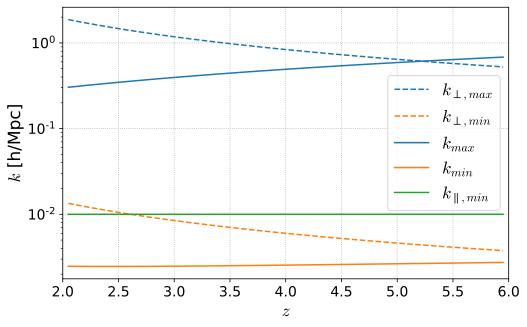

In [25]:
kperpmins = 2 * np.pi / rtobins / theta_FOV
kperpmaxs = 2 * np.pi * D_baseline / rtobins / lambda_z
kperpmins, kperpmaxs

fig, axs = plt.subplots(1,1,sharex=True,figsize=(8,5))
plt.subplots_adjust(wspace=0, hspace=0.125)

plt.semilogy(zbins,kperpmaxs,"--",label="$k_{\perp,max}$")
plt.semilogy(zbins,kperpmins,"--",label="$k_{\perp,min}$")
plt.gca().set_prop_cycle(None)
plt.semilogy(zbins,kmaxs,label="$k_{max}$")
plt.semilogy(zbins,kmins,label="$k_{min}$")
plt.semilogy(zbins,zbins/zbins*0.01,label="$k_{\parallel,min}$")
plt.xlabel("$z$",fontsize=17)
plt.ylabel("$k$ [h/Mpc]",fontsize=17)
plt.legend(fontsize=17)
plt.xlim(2,6)
plt.grid(linestyle=":")
plt.savefig(f"PUMA_k.pdf",format='pdf',bbox_inches='tight')
plt.show()

## First we write the equations for the halo bias

### We will need the smoothed density field using the top hat filter function:
 $$ \sigma^2_{R,n}(M,z) = \frac{1}{2\pi^2} \int dk k^2 k^n W_R(k)^2 P_m(k,z), \\ $$
 $$ W_R(k) = \frac{3j_1(kR)}{kR},\\ $$
 $$ R = \left(\frac{3M}{4 \pi \rho_m}\right)^{1/3} \\ $$
 $$ \rho_m = \Omega^{0}_{m} \rho_c^0 (1+z)^3 $$ 

critical density at z=0 is 2.775370963794208 * 10^11 h^2 M_sol Mpc^-3


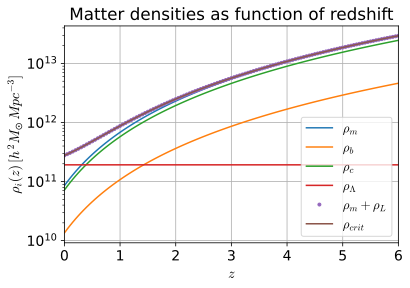

In [26]:
G = 4.30091e-9 # Mpc * M_sol^-1 * (km/s)^2
rho0c = 3*H0**2 / 8 / np.pi / G / h / h  # h^2 M_sol Mpc^-3
rhoz_crit = lambda z: 3*Hofz(z)**2 / 8 / np.pi / G / h / h  # h^2 M_sol Mpc^-3
print("critical density at z=0 is",rho0c*1e-11,"* 10^11 h^2 M_sol Mpc^-3")

rho_m = lambda z: Omega_m * rho0c * (1+z)**3.
rho_b = lambda z: Omega_b * rho0c * (1+z)**3.
rho_c = lambda z: Omega_c * rho0c * (1+z)**3.
rho_L = lambda z: Omega_L * rho0c * (z+1)/(z+1)
plt.semilogy(zs,rho_m(zs),label="$\\rho_m$")
plt.semilogy(zs,rho_b(zs),label="$\\rho_b$")
plt.semilogy(zs,rho_c(zs),label="$\\rho_c$")
plt.semilogy(zs,rho_L(zs),label="$\\rho_\Lambda$")

plt.semilogy(zs,rho_L(zs) + rho_m(zs),".",label="$\\rho_m + \\rho_L$")

plt.semilogy(zs,rhoz_crit(zs),label="$\\rho_{crit}$")
plt.ylabel("$\\rho_i(z) \, [h^2 M_\u2609 \, Mpc^{-3}]$")
plt.title("Matter densities as function of redshift")
plt.xlabel("$z$")
plt.legend(fontsize=13)
plt.xlim(zs[0],zs[-1])
plt.grid()
plt.show()

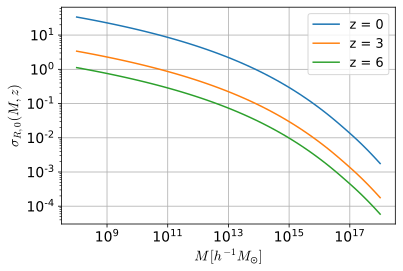

In [27]:
def sigma2(n,M,z,R=None): #insert M in units of M_sol/h
    if np.isscalar(z):
        z = np.array([z])
    if isinstance(z, list):
        z = np.array(z)
    if R==None:
        R = (3 * np.outer(M,1/rho_m(0)) / 4 / np.pi)**(1/3) # (M_sol/h * (h^2 M_sol * Mpc^-3)^-1)^1/3 = Mpc / h
    else:
        R = np.outer(R,np.ones_like(z)) # insert R as Mpc/h

    Plin = PLinIntz(z)
    
    kR = np.einsum("i,jk->ijk",kLin,R) # h/Mpc * Mpc/h = unitless 
    
    WTH = (3*spherical_jn(1, kR) / (kR)) # unitless
     
    integrandp1 = np.einsum("i,ij->ij",kLin**2 * kLin**n ,Plin) # (h/Mpc)^2 * (Mpc/h)^3 = Mpc/h for n = 0
    integrand = np.einsum("ik,ijk->ijk",integrandp1,WTH**2) # Mpc/h
    
    integral = integrate.simpson(integrand,kLin,axis=0) # (Mpc/h) * (h/Mpc) = unitless
    integral *= 1 / 2 / np.pi**2
    
    return integral

Ms = np.logspace(8,18)
plt.loglog(Ms,sigma2(0,Ms,[0,3,6]))
plt.xlabel("$M \, [h^{-1}M_\u2609]$")
plt.ylabel("$\\sigma_{R,0}(M,z)$")
plt.legend([f"z = {z}" for z in [0,3,6]],fontsize=13)
plt.grid()
plt.show()

### We check whether we can make $\sigma_8$ correctly ($\sigma$ at $R = 8$ Mpc$^{-1}/h$ at $z = 0$):
$$ \sigma_8 = \sqrt{\sigma^2_{8,0}(M(R=8),z=0)} \approx 0.82787$$

In [28]:
sigma8 = (sigma2(0,None,0,8)**.5)[0][0]
sigma8

0.8277201289830711

### We define the halo peak
$$ \nu(M,z) = \frac{\delta_c}{ \sqrt{\sigma^2_{R,0}(M,z)}} \\$$
$$ \delta_c = 1.686$$

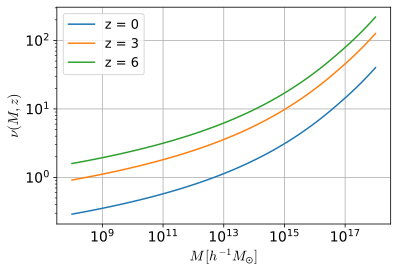

In [29]:
deltac = 1.686

nuofM = lambda M,z : deltac/sigma2(0,M,z)**.5

Ms = np.logspace(8,18)
plt.loglog(Ms,nuofM(Ms,[0,3,6]))
plt.legend([f"z = {z}" for z in [0,3,6]],fontsize=13)
plt.xlabel("$M \, [h^{-1}M_\u2609]$")

plt.grid()
plt.ylabel("$\\nu(M,z)$")
plt.show()

### The halo fitting mass function is given by Tinker et al. (2010) as
$$ f(\nu,z) = \alpha[1+(\beta \nu)^{-2 \phi}] \nu^{2\eta}e^{-\gamma \nu^2/2} \\ $$
$$ \beta(z) = 0.589 (1+z)^{0.2} \\ $$
$$ \phi(z) = -0.729 (1+z)^{-0.08} \\ $$
$$ \eta(z) = -0.243 (1+z)^{0.27} \\ $$
$$ \gamma(z) = 0.864 (1+z)^{-0.01}$$

In [30]:
alpha =  0.368
betaofz  = lambda z:  0.589 * (1+np.fmin(z,3))**(0.20)
phiofz   = lambda z: -0.729 * (1+np.fmin(z,3))**(-0.08)
etaofz   = lambda z: -0.243 * (1+np.fmin(z,3))**(0.27)
gammaofz = lambda z:  0.864 * (1+np.fmin(z,3))**(-0.01)

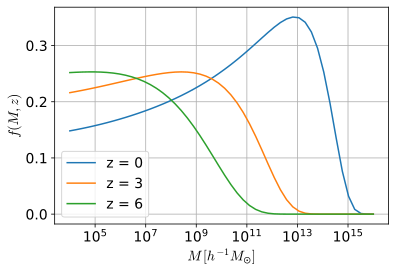

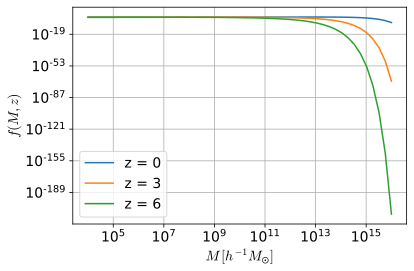

In [31]:
def f(M,z):
    if np.isscalar(z):
        z = np.array([z])
    if isinstance(z, list):
        z = np.array(z)
    nu = nuofM(M,z)
    
    beta  = betaofz(z)
    phi   = phiofz(z)
    eta   = etaofz(z)
    gamma = gammaofz(z)
    
    nu0=1e-6
    norm = (2**(-1/2 + eta - phi)*nu0**(1 + 2*eta)*(gamma*nu0**2)**(-1/2 - eta)*
  (-(2**phi*(-1 + deltac - 2*eta)*(beta*nu0)**(2*phi)*sp.gamma(1/2 + eta, (gamma*nu0**2)/2)) - 
   2**(1 + phi)*(beta*nu0)**(2*phi)*sp.gamma(3/2 + eta, (gamma*nu0**2)/2) + 
   (gamma*nu0**2)**phi*(-((-1 + deltac - 2*eta + 2*phi)*sp.gamma(1/2 + eta - phi, 
        (gamma*nu0**2)/2)) - 2*sp.gamma(3/2 + eta - phi, (gamma*nu0**2)/2))))/(deltac*(beta*nu0)**(2*phi))
    norm*=-1

    return (1 + (beta*nu)**(-2*phi)) * nu**(2*eta+1) * np.exp(-gamma*(nu**2) / 2) / norm

Ms = np.logspace(4,16)

plt.semilogx(Ms,f(Ms,[0,3,6]))
plt.xlabel("$M \, [h^{-1}M_\u2609]$")
plt.ylabel("$f(M,z)$")
plt.legend([f"z = {round(z,2)}" for z in [0,3,6]])
plt.grid()
plt.show()

plt.loglog(Ms,f(Ms,[0,3,6]))
plt.xlabel("$M \, [h^{-1}M_\u2609]$")
plt.ylabel("$f(M,z)$")
plt.legend([f"z = {round(z,2)}" for z in [0,3,6]])
plt.grid()
plt.show()

### From this we obtain the halo mass function
$$ n_h(M,z) = \frac{\rho_m}{M}f(\nu,z)  \frac{d \nu}{d M} \\ $$


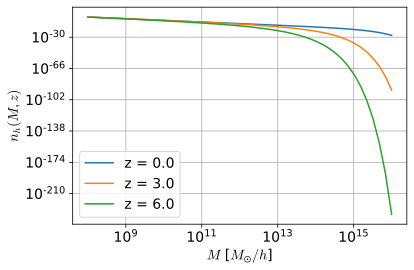

In [32]:
def nh(M,z):
    nu = nuofM(M,z)
    dnudM = np.gradient(nu,M,axis=0)
    return np.outer(1/M,rho_m(0)) * f(M,z) * dnudM / nu

Ms = np.logspace(8,16)

plt.loglog(Ms,nh(Ms,np.linspace(0,6,3)))
plt.xlabel("$M$ [$M_\u2609/h$]")
plt.ylabel("$n_{h}(M,z)$")
plt.legend([f"z = {z}" for z in np.linspace(0,6,3)])
plt.grid()
plt.show()

### Subsequently the n-th order Lagrangian Halo Bias is given by $$ b^L_n = \frac{(-\nu)^n}{\delta_c^n f(\nu,z)} \frac{d^n f(\nu,z)}{d\nu^n}$$ and the eulerian biases in terms of the Lagrangian, are given in 1911.03964

In [33]:
def bL(M,z):
    nu = nuofM(M,z)
    
    beta  = betaofz(z)
    phi   = phiofz(z)
    eta   = etaofz(z)
    gamma = gammaofz(z)
    
    b1L = (2*phi / ((beta*nu)**(2*phi) + 1) + (gamma*nu**2 - 2*eta - 1))/deltac
    b2L = (2*eta + 4*eta**2 - 3*gamma*nu**2 - 4*eta*gamma*nu**2 + gamma**2*nu**4 + (2*phi*(-1 - 4*eta + 2*gamma*nu**2 + 2*phi))/(1 + (beta*nu)**(2*phi)))/deltac**2
    b3L = (2*eta - 8*eta**3 + 3*gamma*nu**2 + 12*eta*gamma*nu**2 + 12*eta**2*gamma*nu**2 - 6*gamma**2*nu**4 - 
  6*eta*gamma**2*nu**4 + gamma**3*nu**6 + 
  (2*phi*(-1 - 6*gamma*nu**2 + 3*(-2*eta + gamma*nu**2)**2 + 6*(-2*eta + gamma*nu**2)*phi + 
     4*phi**2))/(1 + (beta*nu)**(2*phi)))/deltac**3

    
    return b1L, b2L, b3L

In [34]:
def bE(M,z):
    nu = nuofM(M,z)
    beta  = betaofz(z)
    phi   = phiofz(z)
    eta   = etaofz(z)
    gamma = gammaofz(z)
    
    b1L = (2*phi / ((beta*nu)**(2*phi) + 1) + (gamma*nu**2 - 2*eta - 1))/deltac
    b2L = (2*eta + 4*eta**2 - 3*gamma*nu**2 - 4*eta*gamma*nu**2 + gamma**2*nu**4 + (2*phi*(-1 - 4*eta + 2*gamma*nu**2 + 2*phi))/(1 + (beta*nu)**(2*phi)))/deltac**2
    b3L = (2*eta - 8*eta**3 + 3*gamma*nu**2 + 12*eta*gamma*nu**2 + 12*eta**2*gamma*nu**2 - 6*gamma**2*nu**4 - 
  6*eta*gamma**2*nu**4 + gamma**3*nu**6 + 
  (2*phi*(-1 - 6*gamma*nu**2 + 3*(-2*eta + gamma*nu**2)**2 + 6*(-2*eta + gamma*nu**2)*phi + 
     4*phi**2))/(1 + (beta*nu)**(2*phi)))/deltac**3
    
    b1E = 1 + b1L
    b2E =  b2L + 8/21*b1L
    b3E = -796/1323*b1L - 13/7*b2L + b3L
    
    return b1E, b2E, b3E

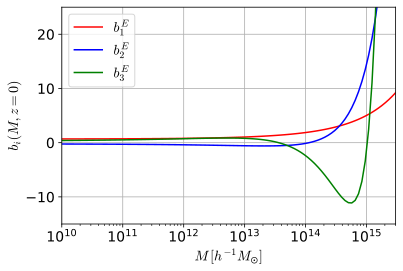

In [35]:
Ms = np.logspace(10,np.log10(3e15),100)

bEofMs = bE(Ms,0)
plt.semilogx(Ms,bEofMs[0],'r',label="$b^E_1$")
plt.semilogx(Ms,bEofMs[1],'b',label="$b^E_2$")
plt.semilogx(Ms,bEofMs[2],'g',label="$b^E_3$")
plt.xlim(Ms[0],Ms[-1])
plt.ylim(-15,25)
plt.grid()
plt.xlabel("$M \, [h^{-1} M_\u2609]$")
plt.ylabel("$b_i(M,z=0)$")
plt.legend()
plt.show()

## We now turn to the Hydrogen Bias

### First we adopt the HOD model from Castorina arXiv:1609.05157

$$ M_{HI}(M,z) = C(z)(1-Y_p)\frac{\Omega_b}{\Omega_m}e^{-M_{min}/M} M^\alpha$$
where $C(z)$ is a normalization and choose $M_{min} = 5\times 10^9  M_{sol}/h$ and $\alpha =1$

In [36]:
def MHI(M,z,Mmin=5e9,alph=1.,Yp=0.24):
    if np.isscalar(z):
        z = np.array([z])
    return np.outer((1-Yp) * Omega_b/Omega_m * np.exp(-Mmin/M) * M**alph, (1+z)/(1+z))

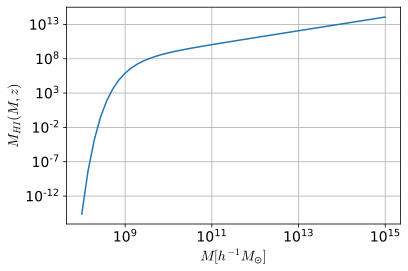

In [37]:
Ms = np.logspace(8,15)
plt.loglog(Ms,MHI(Ms,0))
plt.xlabel("$M [h^{-1} M_\u2609]$")
plt.ylabel("$M_{HI}(M,z)$")
plt.grid()
plt.show()

### The hydrogen bias and shot-noise is then given by

$$ b_{i}^{HI} (z) = \frac{1}{\rho_{HI}(z)} \int_0^\infty n_h(M,z)b^E_i(M,z)M_{HI}(M,z) dM \\ $$

$$ P_{SN}(z) = \frac{1}{\rho_{HI}(z)^2} \int_0^\infty n_h(M,z)M_{HI}^2(M,z) dM \\\\ $$

$$ \rho_{\text{HI}}(z) = \int_0^\infty n_h(M,z)M_{HI}(M,z) dM$$

where the normalization of $M_{HI}$ is irrelevant for these quantities

### We can then normalize it using the fitted Hydrogen fraction 

$$ \Omega_{\text{HI}}(z) = \frac{\rho_{\text{HI}}(z)}{\rho_{c}^0} = 4\times 10^{-4} (1+z)^{0.6}$$

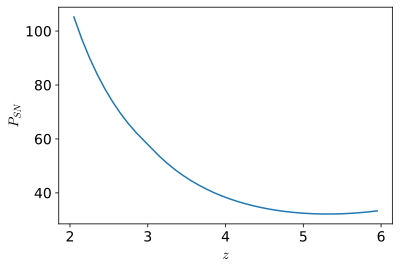

In [38]:
def PSNofz(z,Mmin=5e9,alph=1,Yp=0.24):
    exp = np.log10(Mmin)
    Ms = np.logspace(exp-2,exp+9,1000)
    MHIofM= MHI(Ms,z,Mmin,alph,Yp)
    nhofM = nh(Ms,z)

    integrand_psn = MHIofM**2 * nhofM
    integrand_rho = MHIofM * nhofM
    
    return integrate.simpson(integrand_psn,Ms,axis=0) / integrate.simpson(integrand_rho,Ms,axis=0)**2

PSN = PSNofz(zbins)
plt.plot(zbins,PSN)
plt.ylabel("$P_{SN}$")
plt.xlabel("$z$")
plt.show()

In [39]:
def bHI(bi,z,Mmin=5e9,alph=1,Yp=0.24):
    exp = np.log10(Mmin)
    Ms = np.logspace(exp-4,exp+10,500)
    
    MHIofM= MHI(Ms,z,Mmin,alph,Yp)
    nhofM = nh(Ms,z)
    
    if bi == 1:
        bofM = bE(Ms,z)[0]
    elif bi==2:
        bofM = bE(Ms,z)[1]
    elif bi==3:
        bofM = bE(Ms,z)[2]
    elif bi==4:
        bofM = bE(Ms,z)[2]
    elif bi=='psi_local':
        bofM = 2*deltac*bL(Ms,z)[0]
    elif bi=='psidelta_local':
        bofM = 2*(deltac*bE(Ms,z)[1] + (13/21 * deltac - 1)*(bE(Ms,z)[0]-1))
    elif bi=='s2':
        bofM = -4/7 *(bE(Ms,z)[0] - 1)
    elif bi=='psi_equil':
        alpha = 2
        AA = 3
        sm2 = sigma2(-alpha,Ms,z)
        sm0 = sigma2(0,Ms,z)
        der = np.gradient(np.log(sm2),np.log(Ms),axis=0) / np.gradient(np.log(sm0),np.log(Ms),axis=0)
        bofM = AA * (2*deltac*bL(Ms,z)[0] + 4 * (der - 1)) * sm2/sm0
    elif bi=='psidelta_equil':
        alpha = 2
        AA = 3
        sm2 = sigma2(-alpha,Ms,z)
        sm0 = sigma2(0,Ms,z)
        der = np.gradient(np.log(sm2),np.log(Ms),axis=0) / np.gradient(np.log(sm0),np.log(Ms),axis=0)
        bofM = 2*AA*(deltac*(bE(Ms,z)[1] + 13/21*(bE(Ms,z)[0]-1)) + bE(Ms,z)[0]*(2*der-3)+1)* sm2/sm0

    integrand_rho = MHIofM * nhofM
    integrand_b = MHIofM * nhofM * bofM

    bHIresult = integrate.simpson(integrand_b,Ms,axis=0) / integrate.simpson(integrand_rho,Ms,axis=0)

    return bHIresult

bHI1 = bHI(1,zbins)
bHI2 = bHI(2,zbins)
bHIPsi_local = bHI('psi_local',zbins)
bHIPsiDelta_local = bHI('psidelta_local',zbins)
bHIPsi_equil = bHI('psi_equil',zbins)
bHIPsiDelta_equil = bHI('psidelta_equil',zbins)
bHIs2 = bHI('s2',zbins)

# plt.plot(zbins,bHI1,label="$b^{1}_{HI}$")
# plt.plot(zbins,bHI2,label="$b^{2}_{HI}$")
# plt.plot(zbins,bHIPsi_local,label="$b^{\Psi}_{HI}$")
# plt.plot(zbins,bHIPsiDelta_local,label="$b^{\Psi \delta}_{HI}$")
# plt.plot(zbins,bHIPsi_equil,label="$b^{\Psi}_{HI}$")
# plt.plot(zbins,bHIPsiDelta_equil,label="$b^{\Psi \delta}_{HI}$")
# plt.plot(zbins,bHIs2,label="$b^{s^2}_{HI}$")
# plt.xlabel("$z$")
# plt.ylabel("$b^i_{HI}(z)$")
# plt.xlim(2,6)
# plt.grid()
# plt.legend(loc='upper left')
# # plt.ylim(0,10)
# plt.show()

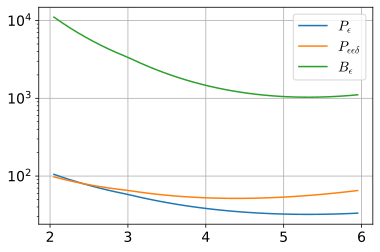

In [40]:
Peps = PSN
Pepsepsdelta = bHI1 * PSN / 2
Beps = PSN**2

plt.semilogy(zbins,Peps,label="$P_{\epsilon}$")
plt.semilogy(zbins,Pepsepsdelta,label="$P_{\epsilon \epsilon \delta}$")
plt.semilogy(zbins,Beps,label="$B_{\epsilon}$")
plt.legend()
plt.grid()
plt.show()

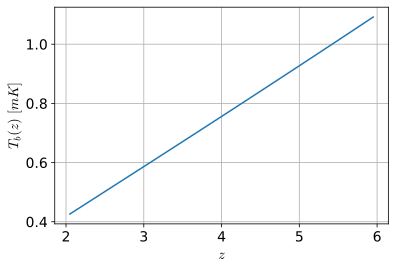

In [41]:
Tb = lambda z: 0.072 * (1+z)**(2.6) / np.sqrt(Omega_m * (1+z)**3 + Omega_k * (1+z) + Omega_L) #mK
Tbz = Tb(zbins)
plt.plot(zbins,Tbz)
plt.xlabel("$z$")
plt.ylabel("$T_b(z)$ $[m K]$")
plt.grid()
plt.show()

### We load the linear growth as computed using $\texttt{CAMB}$
$$f = \frac{d\ln D}{d\ln a}$$

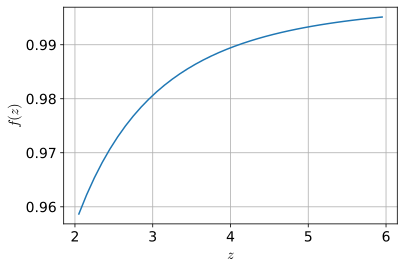

In [42]:
f_growth = np.loadtxt("fgrowth-0-6.dat")[bin_start::bin_skip]

plt.plot(zbins,f_growth)
plt.xlabel("$z$")
plt.ylabel("$f(z)$")
plt.grid()
plt.show()

### The linear velocity is given by $$\sigma_v = \left(\frac{1}{2 \pi^2} \int P_L(k) dk\right)^{1/2}$$

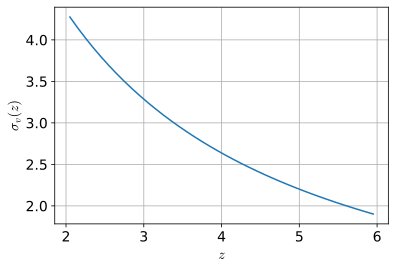

In [43]:
sigmavz = np.sqrt(integrate.simpson(PLin[:,bin_start::bin_skip],kLin,axis=0)/ 2 / np.pi**2) # sqrt((Mpc/h)^3 * (h/Mpc)) = Mpc/h
plt.plot(zbins,sigmavz)
plt.grid()
plt.xlabel("$z$")
plt.ylabel("$\\sigma_v(z)$")
plt.show()

## We define the primordial bispectra

In [44]:
def BLocal(P1prim,P2prim,P3prim):
    return 6/5*(P1prim*P2prim + P1prim*P3prim + P2prim*P3prim)

def BOrtho(P1prim,P2prim,P3prim):
    return 18/5*(-3.*(P1prim*P2prim+P1prim*P3prim+P2prim*P3prim)-8.*np.power(P1prim*P2prim*P3prim,2./3.) + 3.*(np.power(P1prim,1./3.)*np.power(P2prim,2./3.)*P3prim + np.power(P1prim,1./3.)*np.power(P3prim,2./3.)*P2prim + np.power(P2prim,1./3.)*np.power(P1prim,2./3.)*P3prim + np.power(P2prim,1./3.)*np.power(P3prim,2./3.)*P1prim + np.power(P3prim,1./3.)*np.power(P2prim,2./3.)*P1prim + np.power(P3prim,1./3.)*np.power(P1prim,2./3.)*P2prim))

def BEquil(P1prim,P2prim,P3prim):
    return 18/5*(-(P1prim*P2prim+P1prim*P3prim+P2prim*P3prim)-2.*np.power(P1prim*P2prim*P3prim,2./3.) + np.power(P1prim,1./3.)*np.power(P2prim,2./3.)*P3prim + np.power(P1prim,1./3.)*np.power(P3prim,2./3.)*P2prim + np.power(P2prim,1./3.)*np.power(P1prim,2./3.)*P3prim + np.power(P2prim,1./3.)*np.power(P3prim,2./3.)*P1prim + np.power(P3prim,1./3.)*np.power(P2prim,2./3.)*P1prim + np.power(P3prim,1./3.)*np.power(P1prim,2./3.)*P2prim)

## We define the hydrogen bispectrum as well as its derivatives

In [45]:
def K2(k1,k2,k3): #K2(k1,k2) permutation
    kdot = (k3*k3-k1*k1-k2*k2)/2
    kdothat = kdot/k1/k2
    kernel1 = kdothat*(k1/k2 + k2/k1)
    kernel2 = kdothat*kdothat

    FF = 5./7. +  1./2. * kernel1 + 2./7. * kernel2
    GG = 3./7. +  1./2. * kernel1 + 4./7. * kernel2
    SS = kernel2 - 1./3.
    NN1 = kdot/k1**2
    NN2 = kdot/k2**2
    return FF, GG, SS, NN1, NN2 

def dZ2dp(S1,k1,k2,k3,mu1,mu2,TF1,TF2,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth): # Z2(k1,k2) permutation
    mu12 = (mu1*k1 + mu2*k2)/k3
    F2,G2,S2,N21,N22 = K2(k1,k2,k3)
    
    if S1==None: #no derivative
        z1 = b1 + fgrowth * mu1**2
        z2 = b1 + fgrowth * mu2**2

        res = b1 * F2
        res+= fgrowth * mu12**2 * G2
        res+= b2 / 2
        res+= bs2 * S2
        res+= fgrowth * mu12 * k3 / 2 * (mu1/k1 * z2 + mu2/k2 * z1)
        return res
    
    if S1==0: #fnl
        dZ1_1dfnl = (bpsi * k1**alpha) / (5/3 * TF1)
        dZ1_2dfnl = (bpsi * k2**alpha) / (5/3 * TF2)
        res = fgrowth * mu12 * k3 / 2 * (mu1/k1 * dZ1_2dfnl + mu2/k2 * dZ1_1dfnl)
        res+= 1 / 2 * ((bpsidelta - bpsi*N22)*k1**alpha)/(5/3 * TF1)
        res+= 1 / 2 * ((bpsidelta - bpsi*N21)*k2**alpha)/(5/3 * TF2)
        return res
    
    if S1==1: #b1
        res = F2
        res+= fgrowth * mu12 * k3 / 2 * (mu1/k1 + mu2/k2) #from dz1/db1
        return res
    
    if S1==2: #b2
        res = 1./2.
        return res
    
    if S1==3: #bs2
        res = S2
        return res
    
    if S1==4: #fgrowth
        z1 = b1 + fgrowth * mu1**2
        z2 = b1 + fgrowth * mu2**2
        dz1df = mu1**2
        dz2df = mu2**2
        res = mu12**2 * G2
        res+= mu12 * k3 / 2 * (mu1/k1 * z2 + mu2/k2 * z1)
        res+= fgrowth * mu12 * k3 / 2 * (mu1/k1 * dz2df + mu2/k2 * dz1df)
        return res
    
def dBdp(p,k1,k2,k3,mu1,mu2,mu3,TF1,TF2,TF3,P1m,P2m,P3m,Bprim,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep):
    Z1_1 = b1 + fgrowth*mu1**2
    Z1_2 = b1 + fgrowth*mu2**2
    Z1_3 = b1 + fgrowth*mu3**2
    
    Z2_3 = dZ2dp(None,k1,k2,k3,mu1,mu2,TF1,TF2,alpha,b1,b2,bs2,0,0,fgrowth)
    Z2_2 = dZ2dp(None,k1,k3,k2,mu1,mu3,TF1,TF3,alpha,b1,b2,bs2,0,0,fgrowth)
    Z2_1 = dZ2dp(None,k2,k3,k1,mu2,mu3,TF2,TF3,alpha,b1,b2,bs2,0,0,fgrowth)
    
    FOG_B_fact = ((mu1*k1)**2 + (mu2*k2)**2 + (mu3*k3)**2)
    FOG_B = np.exp(-FOG_B_fact*sigmav**2)
    
    if p == None:
        B1 = 2 * Z1_1 * Z1_2 * Z2_3 * P1m * P2m
        B1+= 2 * Z1_1 * Z1_3 * Z2_2 * P1m * P3m
        B1+= 2 * Z1_2 * Z1_3 * Z2_1 * P2m * P3m
        B1*= FOG_B
        
        B1+= 2*Peed*(Z1_1 * P1m + Z1_2 * P2m + Z1_3 * P3m)
        B1+= Bep
    
    elif p == 0: #dBdfnl
        dZ1dfnl_1 = (bpsi * k1**alpha)/(5/3 * TF1)
        dZ1dfnl_2 = (bpsi * k2**alpha)/(5/3 * TF2)
        dZ1dfnl_3 = (bpsi * k3**alpha)/(5/3 * TF3)
        
        dZ2dfnl_3 = dZ2dp(0,k1,k2,k3,mu1,mu2,TF1,TF2,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2dfnl_2 = dZ2dp(0,k1,k3,k2,mu1,mu3,TF1,TF3,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2dfnl_1 = dZ2dp(0,k2,k3,k1,mu2,mu3,TF2,TF3,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
#         B1 = 0
        B1 = h**6 * Z1_1 * Z1_2 * Z1_3 * TF1 * TF2 * TF3 * Bprim
        B1+= 2*(dZ1dfnl_1 * Z1_2 * Z2_3 + Z1_1 * dZ1dfnl_2 * Z2_3 + Z1_1 * Z1_2 * dZ2dfnl_3)*P1m*P2m
        B1+= 2*(dZ1dfnl_1 * Z1_3 * Z2_2 + Z1_1 * dZ1dfnl_3 * Z2_2 + Z1_1 * Z1_3 * dZ2dfnl_2)*P1m*P3m
        B1+= 2*(dZ1dfnl_2 * Z1_3 * Z2_1 + Z1_2 * dZ1dfnl_3 * Z2_1 + Z1_2 * Z1_3 * dZ2dfnl_1)*P2m*P3m
        B1*= FOG_B
        
        B1+= 2*Peed*(dZ1dfnl_1 * P1m + dZ1dfnl_2 * P2m + dZ1dfnl_3 * P3m)
    
    elif p == 1: #dBdb1
        dZ2db1_3 = dZ2dp(1,k1,k2,k3,mu1,mu2,TF1,TF2,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2db1_2 = dZ2dp(1,k1,k3,k2,mu1,mu3,TF1,TF3,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2db1_1 = dZ2dp(1,k2,k3,k1,mu2,mu3,TF2,TF3,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        
        B1 = 2*(Z1_2 * Z2_3 + Z1_1 * Z2_3 + Z1_1 * Z1_2 * dZ2db1_3)*P1m*P2m
        B1+= 2*(Z1_3 * Z2_2 + Z1_1 * Z2_2 + Z1_1 * Z1_3 * dZ2db1_2)*P1m*P3m
        B1+= 2*(Z1_3 * Z2_1 + Z1_2 * Z2_1 + Z1_2 * Z1_3 * dZ2db1_1)*P2m*P3m
        B1*= FOG_B
        
        B1+= 2*Peed*(P1m + P2m + P3m) #dZ1db1 = 1
        
    elif p == 2: #dBdb2
        dZ2db2_3 = dZ2dp(2,k1,k2,k3,mu1,mu2,TF1,TF2,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2db2_2 = dZ2dp(2,k1,k2,k3,mu1,mu2,TF1,TF2,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2db2_1 = dZ2dp(2,k1,k2,k3,mu1,mu2,TF1,TF2,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        
        B1 = 2*(Z1_1 * Z1_2 * dZ2db2_3)*P1m*P2m
        B1+= 2*(Z1_1 * Z1_3 * dZ2db2_2)*P1m*P3m
        B1+= 2*(Z1_2 * Z1_3 * dZ2db2_1)*P2m*P3m
        B1*= FOG_B
        
    elif p == 3: #dBdbs2
        dZ2dbs2_3 = dZ2dp(3,k1,k2,k3,mu1,mu2,TF1,TF2,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2dbs2_2 = dZ2dp(3,k1,k3,k2,mu1,mu3,TF1,TF3,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2dbs2_1 = dZ2dp(3,k2,k3,k1,mu2,mu3,TF2,TF3,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        
        B1 = 2*(Z1_1 * Z1_2 * dZ2dbs2_3)*P1m*P2m
        B1+= 2*(Z1_1 * Z1_3 * dZ2dbs2_2)*P1m*P3m
        B1+= 2*(Z1_2 * Z1_3 * dZ2dbs2_1)*P2m*P3m
        B1*= FOG_B    
        
    elif p == 4: #dBdfgrowth
        dZ1df_1 = mu1**2
        dZ1df_2 = mu2**2
        dZ1df_3 = mu3**2
        
        dZ2df_3 = dZ2dp(4,k1,k2,k3,mu1,mu2,TF1,TF2,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2df_2 = dZ2dp(4,k1,k3,k2,mu1,mu3,TF1,TF3,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        dZ2df_1 = dZ2dp(4,k2,k3,k1,mu2,mu3,TF2,TF3,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth)
        
        B1 = 2*(dZ1df_1 * Z1_2 * Z2_3 + Z1_1 * dZ1df_2 * Z2_3 + Z1_1 * Z1_2 * dZ2df_3)*P1m*P2m
        B1+= 2*(dZ1df_1 * Z1_3 * Z2_2 + Z1_1 * dZ1df_3 * Z2_2 + Z1_1 * Z1_3 * dZ2df_2)*P1m*P3m
        B1+= 2*(dZ1df_2 * Z1_3 * Z2_1 + Z1_2 * dZ1df_3 * Z2_1 + Z1_2 * Z1_3 * dZ2df_1)*P2m*P3m
        B1*= FOG_B
        
        B1+= 2*Peed*(dZ1df_1 * P1m + dZ1df_2 * P2m + dZ1df_3 * P3m)
        
    elif p == 5: #dB/dsigma_v
        dFOGdsigma = -2 * FOG_B_fact * sigmav * FOG_B
        B1 = 2 * Z1_1 * Z1_2 * Z2_3 * P1m * P2m
        B1+= 2 * Z1_1 * Z1_3 * Z2_2 * P1m * P3m
        B1+= 2 * Z1_2 * Z1_3 * Z2_1 * P2m * P3m
        B1*= dFOGdsigma
        
    elif p == 6: #dB/dPepsepsdelta
        B1 = 2*(Z1_1 * P1m + Z1_2 * P2m + Z1_3 * P3m)
        
    elif p == 7: #dB/dBepsilon
        B1 = np.ones_like(FOG_B_fact)
        
    return B1

### We compute the signal-to-noise with only Gaussian covariance

In [89]:
def GaussianIntegrand(k,kmin,kmax,kpmin,kpmax,zi,S1,S2,BShape,Nw,kzcut,TFInt,Tb,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep,inst_noise):
    result_full = np.zeros(len(k))
    
    wedgefac = kwedgePBfactor(Nw)[zi]
    kpmax = np.fmin(kmax,kpmax) #choose the smallest of the kmaxes for the perpendicular direction
    
    k1p = kpmin + k[:,0] * (kpmax-kpmin)
    k1zmin = wedgefac*k1p
    k1zmin = np.fmax(kzcut,k1zmin) #choose the biggest of the kmins in the z-direction: either the wedge or the z-cut
    k1zmax = np.sqrt(kmax**2 - k1p**2)
    k1z = np.sign(k[:,1]) * (k1zmin + np.abs(k[:,1]) * (k1zmax-k1zmin))
    k1  = np.sqrt(k1p**2 + k1z**2)
    
    k2p = kpmin + k[:,2] * (kpmax-kpmin)
    k2zmin = wedgefac*k2p
    k2zmin = np.fmax(kzcut,k2zmin) #choose the biggest of the kmins in the z-direction: either the wedge or the z-cut
    k2zmax = np.sqrt(kmax**2 - k2p**2)
    k2z = np.sign(k[:,3]) * (k2zmin + np.abs(k[:,3]) * (k2zmax-k2zmin))
    k2  = np.sqrt(k2p**2 + k2z**2)
    
    dVol = 2 * 2 * 2*np.pi * (kpmax-kpmin) * (kpmax-kpmin) * (k1zmax-k1zmin) * (k2zmax-k2zmin) * k1p * k2p
    
    phi12 = k[:,4]
    
    k3p = np.sqrt(k1p**2 + k2p**2 + 2*k1p*k2p*np.cos(phi12))
    k3zmin = wedgefac*k3p
    k3zmin = np.fmax(kzcut,k3zmin)
    k3z = -k1z-k2z
    k3  = np.sqrt(k3p**2 + k3z**2)
    
    bools = k1 < k1
    for kq in [k1,k2,k3]:
        bools+= kq < kmin
        bools+= kq > kmax
        
    for kqp in [k1p,k2p,k3p]:
        bools+= kqp > kpmax
        bools+= kqp < kpmin

    bools+= np.abs(k1z) < k1zmin
    bools+= np.abs(k2z) < k2zmin
    bools+= np.abs(k3z) < k3zmin
    
    inv_bools = ~bools
    
    k1, k2, k3, k1p, k2p, k3p, k1z, k2z, k3z = k1[inv_bools], k2[inv_bools], k3[inv_bools], k1p[inv_bools], k2p[inv_bools], k3p[inv_bools], k1z[inv_bools], k2z[inv_bools], k3z[inv_bools]
    
    mu1 = k1z / k1
    mu2 = k2z / k2
    mu3 = k3z / k3
    
    P1prim = Pprim(k1*h)
    P2prim = Pprim(k2*h)
    P3prim = Pprim(k3*h)
    
    TF1 = TFInt(k1)
    TF2 = TFInt(k2)
    TF3 = TFInt(k3)
    
    P1m = h**3 * TF1**2 * P1prim
    P2m = h**3 * TF2**2 * P2prim
    P3m = h**3 * TF3**2 * P3prim
    
    if BShape == BLocal:
        alpha = 0.
    if BShape == BEquil:
        alpha = 2.
        
    Bprim = BShape(P1prim,P2prim,P3prim)
    
    Z1_1 = b1 + fgrowth*mu1**2
    Z1_2 = b1 + fgrowth*mu2**2
    Z1_3 = b1 + fgrowth*mu3**2
    
    P1HI = Tb**2 * (np.exp(-(k1z*sigmav)**2) * Z1_1**2 * P1m + Pep) + PN(k1p,zi) * inst_noise
    P2HI = Tb**2 * (np.exp(-(k2z*sigmav)**2) * Z1_2**2 * P2m + Pep) + PN(k2p,zi) * inst_noise
    P3HI = Tb**2 * (np.exp(-(k3z*sigmav)**2) * Z1_3**2 * P3m + Pep) + PN(k3p,zi) * inst_noise
    dBHIdp1XdBHIdp2 = 1.
    
    if S1==S2:
        dBHIdp1XdBHIdp2 *= (Tb**3 * dBdp(S1,k1,k2,k3,mu1,mu2,mu3,TF1,TF2,TF3,P1m,P2m,P3m,Bprim,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep))**2
    else:
        dBHIdp1XdBHIdp2 *= Tb**3 * dBdp(S1,k1,k2,k3,mu1,mu2,mu3,TF1,TF2,TF3,P1m,P2m,P3m,Bprim,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep)
        dBHIdp1XdBHIdp2 *= Tb**3 * dBdp(S2,k1,k2,k3,mu1,mu2,mu3,TF1,TF2,TF3,P1m,P2m,P3m,Bprim,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep)
        
    result = dBHIdp1XdBHIdp2 / P1HI / P2HI / P3HI / 6
    result *= Vbins[zi]/(2*np.pi)**6 * dVol[inv_bools]
    
    result_full[inv_bools] = result
    return result_full
    

def Gaussian(zi,S1,S2,BShape,kmin=None,kmax=None,kpmin=None,kpmax=None,Nw=0,kzcut=0.00,DM=False,verbose=0,rtol=1e-3):
    #zi is the number of the zbin
    #S1,S2 are the index of the parameters to differentiate to
    #kmin,kmax,kpmin,kpmax are optional to manually set the k-ranges, otherwise defaults to the values set by binning+experiment (see below)
    #Nw sets the amount of wedge cut
    #kzcut sets the parallel foreground cut (typically 0 or 0.01)
    #DM is a switch to turn of all biases and parameters and default to a Dark Matter only setup
    #Verbose prints intermediate results from integration
    
    #if no manual value given, default to values of the binning + experiment
    if kmin==None: kmin = kmins[zi]
    if kmax==None: kmax = kmaxs[zi]
    if kpmin==None:kpmin = kperpmins[zi]
    if kpmax==None:kpmax = kperpmaxs[zi]

    if verbose:
        print(zi,zbins[zi],kmin,kmax,kpmin,kpmax,S1,S2,Vbins[zi])
        
    #setup interpolator for the transferfunction at the given redshift zi
    TFInt = interpolate(k_transfer,Tc[:,zi],ext=2)
    
    if DM:
        Tb, b1, b2, bs2, bpsi, bpsidelta, fgrowth, sigmav, inst_noise, Pep, Peed, Bep = 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        S1 = S2 = 0
    
    else:
        Tb = Tbz[zi]
        b1 = bHI1[zi]
        b2 = bHI2[zi]
        bs2 = bHIs2[zi]
        if BShape == BLocal:
            bpsi = bHIPsi_local[zi]
            bpsidelta =bHIPsiDelta_local[zi]
        if BShape == BEquil:
            bpsi = bHIPsi_equil[zi]
            bpsidelta = bHIPsiDelta_equil[zi]
        fgrowth = f_growth[zi]
        sigmav = sigmavz[zi]
        inst_noise = 1.
        Pep = Peps[zi]
        Peed = Pepsepsdelta[zi]
        Bep = Beps[zi]
    
    #Below is the VEGAS integration section
    @vegas.batchintegrand
    def integrandbatch(k):
        return GaussianIntegrand(k,kmin,kmax,kpmin,kpmax,zi,S1,S2,BShape,Nw,kzcut,TFInt,Tb,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep,inst_noise)
    
    integ = vegas.Integrator([[0,1],[0,1],[0,1],[-1,1],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=1e-2)
    if verbose:
        print(pre.summary())
    
    results = integ(integrandbatch,nitn=10,neval=1e6,rtol=rtol)
    if verbose:
        print(results.summary())
        
    mean = results.mean
    rerr = np.sqrt(results.var/mean**2)
    
    if rerr > rtol:
        results = integ(integrandbatch,nitn=10,neval=1e7,rtol=rtol)
        if verbose:
            print(results.summary())
        mean = results.mean
        rerr = np.sqrt(results.var/mean**2)
    
    return zi,S1,S2,mean, rerr

%time Gaussian(0,1,1,BEquil,Nw=3,kzcut=0.01,verbose=1,rtol=1e-3)

0 2.0500000000000003 0.0024749819950876497 0.30383519817215077 0.013417901440709984 1.8710369625693375 1 1 8180756719.412915
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   858601(4525)    858601(4525)        0.00     1.00

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   855614(999)     855614(999)         0.00     1.00
  2   857733(586)     857191(505)         3.35     0.07

CPU times: user 1.88 s, sys: 276 ms, total: 2.16 s
Wall time: 2.22 s


(0, 1, 1, 857190.8987217578, 0.0005893059078632954)

### We define the noise due to non-Gaussian covariance from the bispectrum (since we don't have the hydrogen Trispectrum we use twice this noise as suggested in Biagetti et al. 2021)

In [92]:
def NonGaussIntegrandBB(k,kmin,kmax,kpmin,kpmax,zi,S1,S2,BShape,Nw,kzcut,TFInt,Tb,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep,inst_noise):
    result_full = np.zeros(len(k))
    
    wedgefac = kwedgePBfactor(Nw)[zi]
    kpmax = np.fmin(kmax,kpmax)
    
    k1p = kpmin + k[:,0] * (kpmax - kpmin)
    k1zmin = wedgefac*k1p
    k1zmin = np.fmax(kzcut,k1zmin)
    k1zmax = np.sqrt(kmax**2 - k1p**2)
    k1z = np.sign(k[:,1]) * (k1zmin + np.abs(k[:,1]) * (k1zmax-k1zmin))
    phik1 = 0
    k1 = np.sqrt(k1p**2 + k1z**2)
    
    k2p = kpmin + k[:,2] * (kpmax - kpmin)
    k2zmin = wedgefac*k2p
    k2zmin = np.fmax(kzcut,k2zmin)
    k2zmax = np.sqrt(kmax**2 - k2p**2)
    k2z = np.sign(k[:,3]) * (k2zmin + np.abs(k[:,3]) * (k2zmax-k2zmin))
    phik2 = k[:,4]
    k2 = np.sqrt(k2p**2 + k2z**2)
    
    k3p = np.sqrt(k1p**2 + k2p**2 + 2*k1p*k2p*np.cos(phik1-phik2))
    k3zmin = wedgefac*k3p
    k3z = -k1z-k2z
    k3 = np.sqrt(k3p**2 + k3z**2)
    
    q1p = k3p
    q1zmin = wedgefac*q1p
    q1z = k3z
    q1 = np.sqrt(q1p**2 + q1z**2)
    
    q2p = kpmin + k[:,5] * (kpmax - kpmin)
    q2zmin = wedgefac*q2p
    q2zmin = np.fmax(kzcut,q2zmin)
    q2zmax = np.sqrt(kmax**2 - q2p**2)
    q2z = np.sign(k[:,6]) * (q2zmin + np.abs(k[:,6]) * (q2zmax-q2zmin))
    phiq2 = k[:,7]
    q2 = np.sqrt(q2p**2 + q2z**2)
    
    q3p = np.sqrt(k1p**2 + k2p**2 + q2p**2 + 2*k1p*k2p*np.cos(phik1-phik2) - 2*q2p*k1p*np.cos(phik1-phiq2) - 2*q2p*k2p*np.cos(phik2-phiq2))
    q3zmin = wedgefac*q3p
    q3z = k1z+k2z-q2z
    q3 = np.sqrt(q3p**2 + q3z**2)
    
    # jacobian, 2*pi comes from the k1 angular integral, 2 comes from halving one of the angular integrals, 2 comes from halving the k1z direction
    dVol = 2 * 2 * 2*np.pi * k1p * k2p * q2p * (kpmax-kpmin) * (kpmax-kpmin) * (kpmax-kpmin) * (k1zmax-k1zmin) * (k2zmax-k2zmin) * (q2zmax-q2zmin)

    bools = k1 < k1
    for kq in [k1,k2,k3,q1,q2,q3]:
        bools+= kq < kmin
        bools+= kq > kmax
        
    for kqz in [k1z,k2z,k3z,q1z,q2z,q3z]:
        bools+= np.abs(kqz) < kzcut
        
    for kqp in [k1p,k2p,k3p,q1p,q2p,q3p]:
        bools+= kqp > kpmax
        bools+= kqp < kpmin
    
    bools+= np.abs(k1z) < k1zmin
    bools+= np.abs(k2z) < k2zmin
    bools+= np.abs(k3z) < k3zmin
    bools+= np.abs(q1z) < q1zmin
    bools+= np.abs(q2z) < q2zmin
    bools+= np.abs(q3z) < q3zmin
    
    inv_bools = ~bools
    
    k1, k2, k3, q1, q2, q3 = k1[inv_bools], k2[inv_bools], k3[inv_bools], q1[inv_bools], q2[inv_bools], q3[inv_bools]
    k1p, k2p, k3p, q1p, q2p, q3p = k1p[inv_bools], k2p[inv_bools], k3p[inv_bools], q1p[inv_bools], q2p[inv_bools], q3p[inv_bools]
    k1z, k2z, k3z, q1z, q2z, q3z = k1z[inv_bools], k2z[inv_bools], k3z[inv_bools], q1z[inv_bools], q2z[inv_bools], q3z[inv_bools]
    
    muk1 = k1z / k1
    muk2 = k2z / k2
    muk3 = k3z / k3
    muq1 = q1z / q1
    muq2 = q2z / q2
    muq3 = q3z / q3
    
    TFk1 = TFInt(k1)
    TFk2 = TFInt(k2)
    TFk3 = TFInt(k3)
    TFq1 = TFInt(q1)
    TFq2 = TFInt(q2)
    TFq3 = TFInt(q3)
    
    Pk1prim = Pprim(k1*h)
    Pk2prim = Pprim(k2*h)
    Pk3prim = Pprim(k3*h)
    Pq1prim = Pprim(q1*h)
    Pq2prim = Pprim(q2*h)
    Pq3prim = Pprim(q3*h)
    
    Pk1m = h**3 * TFk1**2 * Pk1prim
    Pk2m = h**3 * TFk2**2 * Pk2prim
    Pk3m = h**3 * TFk3**2 * Pk3prim
    Pq1m = h**3 * TFq1**2 * Pq1prim
    Pq2m = h**3 * TFq2**2 * Pq2prim
    Pq3m = h**3 * TFq3**2 * Pq3prim
    
    Z1_k1 = b1 + fgrowth*muk1**2
    Z1_k2 = b1 + fgrowth*muk2**2
    Z1_k3 = b1 + fgrowth*muk3**2
    Z1_q1 = b1 + fgrowth*muq1**2
    Z1_q2 = b1 + fgrowth*muq2**2
    Z1_q3 = b1 + fgrowth*muq3**2
    
    if BShape == BLocal:
        alpha = 0.
    if BShape == BEquil:
        alpha = 2.

    Bkprim = BShape(Pk1prim,Pk2prim,Pk3prim)
    Bqprim = BShape(Pq1prim,Pq2prim,Pq3prim)
    
    Pk1HI = Tb**2 * (np.exp(-(k1z*sigmav)**2) * Z1_k1**2 * Pk1m + Pep) + PN(k1p,zi) * inst_noise
    Pk2HI = Tb**2 * (np.exp(-(k2z*sigmav)**2) * Z1_k2**2 * Pk2m + Pep) + PN(k2p,zi) * inst_noise
    Pk3HI = Tb**2 * (np.exp(-(k3z*sigmav)**2) * Z1_k3**2 * Pk3m + Pep) + PN(k3p,zi) * inst_noise
    Pq1HI = Tb**2 * (np.exp(-(q1z*sigmav)**2) * Z1_q1**2 * Pq1m + Pep) + PN(q1p,zi) * inst_noise
    Pq2HI = Tb**2 * (np.exp(-(q2z*sigmav)**2) * Z1_q2**2 * Pq2m + Pep) + PN(q2p,zi) * inst_noise
    Pq3HI = Tb**2 * (np.exp(-(q3z*sigmav)**2) * Z1_q3**2 * Pq3m + Pep) + PN(q3p,zi) * inst_noise

    W1 = Tb**3 * dBdp(S1,k1,k2,k3,muk1,muk2,muk3,TFk1,TFk2,TFk3,Pk1m,Pk2m,Pk3m,Bkprim,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep) / 6 / Pk1HI / Pk2HI / Pk3HI
    W2 = Tb**3 * dBdp(S2,q1,q2,q3,muq1,muq2,muq3,TFq1,TFq2,TFq3,Pq1m,Pq2m,Pq3m,Bqprim,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep) / 6 / Pq1HI / Pq2HI / Pq3HI
    
    BS1 = Tb**3 * dBdp(None,k1,k2,k3,muk1,muk2,muk3,TFk1,TFk2,TFk3,Pk1m,Pk2m,Pk3m,Bkprim,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep)
    
    BS2 = Tb**3 * dBdp(None,q1,q2,q3,muq1,muq2,muq3,TFq1,TFq2,TFq3,Pq1m,Pq2m,Pq3m,Bqprim,alpha,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep)
    
    result = 9*W1*W2*BS1*BS2 * Vbins[zi]/(2*np.pi)**9
    result *= dVol[inv_bools]
    
    result_full[inv_bools] = result
    
    return result_full

def NonGaussBB(zi,S1,S2,BShape,kmin=None,kmax=None,kpmin=None,kpmax=None,Nw=0,kzcut=0.00,DM=False,verbose=0,rtol=1e-3):
    if kmin==None: kmin = kmins[zi]
    if kmax==None: kmax = kmaxs[zi]
    if kpmin==None:kpmin = kperpmins[zi]
    if kpmax==None:kpmax = kperpmaxs[zi]
    
    if verbose:
        print(zi,zbins[zi],kmin,kmax,kpmin,kpmax,S1,S2)
    
    TFInt = interpolate(k_transfer,Tc[:,zi],ext=2)
    
    if DM:
        Tb, b1, b2, bs2, bpsi, bpsidelta, fgrowth, sigmav, inst_noise, Pep, Peed, Bep = 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        S1 = S2 = 0
    
    else:
        Tb = Tbz[zi]
        b1 = bHI1[zi]
        b2 = bHI2[zi]
        bs2 = bHIs2[zi]
        if BShape == BLocal:
            bpsi = bHIPsi_local[zi]
            bpsidelta =bHIPsiDelta_local[zi]
        if BShape == BEquil:
            bpsi = bHIPsi_equil[zi]
            bpsidelta = bHIPsiDelta_equil[zi]
        fgrowth = f_growth[zi]
        sigmav = sigmavz[zi]
        inst_noise = 1.
        Pep = Peps[zi]
        Peed = Pepsepsdelta[zi]
        Bep = Beps[zi]
    
    @vegas.batchintegrand
    def integrandbatch(k):
        return NonGaussIntegrandBB(k,kmin,kmax,kpmin,kpmax,zi,S1,S2,BShape,Nw,kzcut,TFInt,Tb,b1,b2,bs2,bpsi,bpsidelta,fgrowth,sigmav,Pep,Peed,Bep,inst_noise)

    integ = vegas.Integrator([[0,1],[0,1],[0,1],[-1,1],[0,2*np.pi],[0,1],[-1,1],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=1e-2)
    if verbose!=0:
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e6,rtol=rtol)
    if verbose!=0:
        print(results.summary())
        
    mean = results.mean
    rerr = np.sqrt(results.var/mean**2)
    
    if rerr > rtol:
        results = integ(integrandbatch,nitn=10,neval=1e7,rtol=rtol)
        if verbose:
            print(results.summary())
        mean = results.mean
        rerr = np.sqrt(results.var/mean**2)

    return zi,S1,S2,mean, rerr

%time NonGaussBB(0,0,0,BEquil,Nw=3,kzcut=0.01,verbose=1,rtol=1e-3)

0 2.0500000000000003 0.0024749819950876497 0.30383519817215077 0.013417901440709984 1.8710369625693375 0 0
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.1066(19)      0.1066(19)          0.00     1.00
  2   0.1065(13)      0.1065(11)          0.00     0.97

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.10545(36)     0.10545(36)         0.00     1.00
  2   0.10617(25)     0.10593(21)         2.69     0.10
  3   0.10631(23)     0.10610(15)         2.10     0.12
  4   0.10571(21)     0.10596(12)         2.12     0.10
  5   0.10552(19)     0.10583(10)         2.51     0.04

CPU times: user 7.9 s, sys: 1.13 s, total: 9.03 s
Wall time: 9.18 s


(0, 0, 0, 0.10583032791485675, 0.0009815018903583628)

## Compute signal and noise terms at each redshift z

In [ ]:
## compute once the #z x 7 x 7 Noise from the non-f_NL parameters (do it every 3rd z-bin to save time)
GaussData = np.array(Parallel(n_jobs=-1,verbose=10)([delayed(Gaussian)(zi,S1,S2,BLocal,Nw=3,kzcut=0.01,verbose=0,rtol=1e-4) for zi in range(len(zbins))[::3] for S1 in range(1,8) for S2 in range(1,S1+1)][::-1]))[::-1]
np.save("GaussianData_7params_Full_Nw3_kzcut0.01_every3z_rtol0.0001",GaussData)
NonGaussData =  np.array(Parallel(n_jobs=-1,verbose=10)([delayed(NonGaussBB)(zi,S1,S2,BLocal,Nw=3,kzcut=0.01,verbose=0,rtol=1e-4) for zi in range(len(zbins))[::3] for S1 in range(1,8) for S2 in range(1,S1+1)][::-1]))[::-1]
np.save("NonGaussianData_7params_Full_Nw3_kzcut0.01_every3z_rtol0.0001",NonGaussData)

In [ ]:
## compute once the #z x 1 x 8 Noise of f_NL with other parameters and itself for Local pnG (do it every 3rd z-bin to save time)
GaussData = np.array(Parallel(n_jobs=-1,verbose=10)([delayed(Gaussian)(zi,S1,0,BLocal,Nw=3,kzcut=0.01,verbose=0,rtol=1e-4) for zi in range(len(zbins))[::3] for S1 in range(8)]))
np.save("GaussianData_Local_Full_Nw3_kzcut0.01_every3z_rtol0.0001",GaussData)
NonGaussData =  np.array(Parallel(n_jobs=-1,verbose=10)([delayed(NonGaussBB)(zi,S1,0,BLocal,Nw=3,kzcut=0.01,verbose=0,rtol=1e-4) for zi in range(len(zbins))[::3] for S1 in range(8)]))
np.save("NonGaussianData_Local_Full_Nw3_kzcut0.01_every3z_rtol0.0001",NonGaussData)

## compute the #z x 1 x 1 Noise for f_NL for the DM field for Local pnG (this can quickly be done at every z-bin)
GaussData = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(Gaussian)(zi,S1,S2,BEquil,Nw=3,kzcut=0.01,DM=True,verbose=0) for zi in range(len(zbins)) for S1 in range(1) for S2 in range(0,S1+1)][::-1]))[::-1]
np.save("GaussianData_Local_DM_Nw3_kzcut0.01",GaussData)
NonGaussData =  np.array(Parallel(n_jobs=-1,verbose=1)([delayed(NonGaussBB)(zi,S1,S2,BEquil,Nw=3,kzcut=0.01,DM=True,verbose=0) for zi in range(len(zbins)) for S1 in range(1) for S2 in range(0,S1+1)][::-1]))[::-1]
np.save("NonGaussianData_Local_DM_Nw3_kzcut0.01",NonGaussData)

In [ ]:
## compute once the #z x 1 x 8 Noise of f_NL with other parameters and itself for Equilateral pnG (do it every 3rd z-bin to save time)
GaussData = np.array(Parallel(n_jobs=-1,verbose=10)([delayed(Gaussian)(zi,S1,0,BEquil,Nw=3,kzcut=0.01,verbose=0,rtol=1e-4) for zi in range(len(zbins))[::3] for S1 in range(8)]))
np.save("GaussianData_EquilwithSDB_Full_Nw3_kzcut0.01_every3z_rtol0.0001",GaussData)
NonGaussData =  np.array(Parallel(n_jobs=-1,verbose=10)([delayed(NonGaussBB)(zi,S1,0,BEquil,Nw=3,kzcut=0.01,verbose=0,rtol=1e-4) for zi in range(len(zbins))[::3] for S1 in range(8)]))
np.save("NonGaussianData_Equil_Full_Nw3_kzcut0.01_every3z_rtol0.0001",NonGaussData)

## compute the #z x 1 x 1 Noise for f_NL for the DM field for Equilateral pnG (this can quickly be done at every z-bin)
GaussData = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(Gaussian)(zi,S1,S2,BEquil,Nw=3,kzcut=0.01,DM=True,verbose=0) for zi in range(len(zbins)) for S1 in range(1) for S2 in range(0,S1+1)][::-1]))[::-1]
np.save("GaussianData_Equil_DM_Nw3_kzcut0.01",GaussData)
NonGaussData =  np.array(Parallel(n_jobs=-1,verbose=1)([delayed(NonGaussBB)(zi,S1,S2,BEquil,Nw=3,kzcut=0.01,DM=True,verbose=0) for zi in range(len(zbins)) for S1 in range(1) for S2 in range(0,S1+1)][::-1]))[::-1]
np.save("NonGaussianData_Equil_DM_Nw3_kzcut0.01",NonGaussData)

## Build actual Fishers, compute S/N and plot the ratio of Gaussian to non-Gaussian signal-to-noise

0.21695335748518332
0.5282198790995953


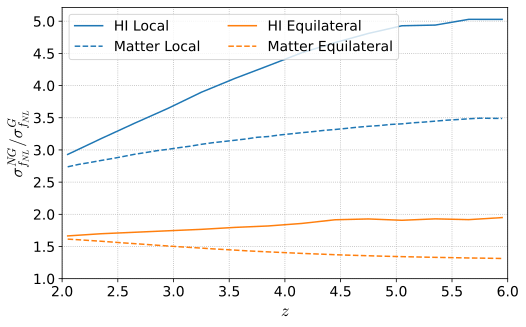

In [18]:
nbins = len(zbins[::3])

fig, axs = plt.subplots(1,1,sharex=True,figsize=(8,5))
plt.subplots_adjust(wspace=0, hspace=0.125)

for ii in range(1):
    for shape in ["Local","Equil"]:
        Gauss = np.zeros((nbins,8,8))
        NonGauss = np.zeros((nbins,8,8))

        GaussData_nuisance = np.load("Results/GaussianData_7params_Full_Nw3_kzcut0.01_every3z_rtol0.0001.npy")
        NonGaussData_nuisance = np.load("Results/NonGaussianData_7params_Full_Nw3_kzcut0.01_every3z_rtol0.0001.npy")

        GaussData_fnl = np.load(f"Results/GaussianData_{shape}_Full_Nw3_kzcut0.01_every3z_rtol0.0001.npy")
        NonGaussData_fnl = np.load(f"Results/NonGaussianData_{shape}_Full_Nw3_kzcut0.01_every3z_rtol0.0001.npy")

        GaussData_DM = np.load(f"Results/GaussianData_{shape}_DM_Nw3_kzcut0.01.npy")
        NonGaussData_DM = np.load(f"Results/NonGaussianData_{shape}_DM_Nw3_kzcut0.01.npy")

        a=0
        for zi in range(nbins):
            for S1 in range(1,8):
                for S2 in range(1,S1+1):
                    Gauss[zi,S1,S2] = Gauss[zi,S2,S1] = GaussData_nuisance[a,-2]
                    NonGauss[zi,S1,S2] = NonGauss[zi,S2,S1] = NonGaussData_nuisance[a,-2]
                    a+=1

        a=0
        for zi in range(nbins):
            for S1 in range(8):
                    Gauss[zi,S1,0] = Gauss[zi,0,S1] = GaussData_fnl[a,-2]
                    NonGauss[zi,S1,0] = NonGauss[zi,0,S1] = NonGaussData_fnl[a,-2]
                    a+=1

        FishG = Gauss
        FishNG= Gauss**2 / (Gauss + 2*NonGauss)
        FishG_Inv = np.linalg.inv(FishG[:,:,:])
        FishNG_Inv = np.linalg.inv(FishNG[:,:,:])

        SNG = FishG[:,0,0]**.5
        SNNG= FishNG[:,0,0]**.5
        R = SNNG/SNG

        SNGmarg = FishG_Inv[:,0,0]**(-.5)
        SNNGmarg= FishNG_Inv[:,0,0]**(-.5)
        Rmarg = SNNGmarg/SNGmarg

        FishG_DM = GaussData_DM[:,-2]
        FishNG_DM = GaussData_DM[:,-2]**2 / (GaussData_DM[:,-2] + 2*NonGaussData_DM[:,-2])

        SNG_DM = FishG_DM**.5
        SNNG_DM = FishNG_DM**.5
        R_DM = SNNG_DM/SNG_DM

        print((FishG_Inv[:,0,0]**-1).sum()**-.5 / (FishNG_Inv[:,0,0]**-1).sum()**-.5)
        
        if shape == 'Local':
            plt.plot(zbins[::3],Rmarg**-1,"-",color='tab:blue',label=f'HI Local')
            plt.plot(zbins,R_DM**-1,"--",color='tab:blue',label=f"Matter Local")
        if shape == 'Equil':
            plt.plot(zbins[::3],Rmarg**-1,"-",color='tab:orange',label=f'HI Equilateral')
            plt.plot(zbins,R_DM**-1,"--",color='tab:orange',label=f"Matter Equilateral")
    
plt.ylabel("$\sigma_{f_{NL}}^{NG}/\sigma^{G}_{f_{NL}}$",fontsize=17)
plt.legend(ncol=2,fontsize=14)
plt.xlabel('$z$',fontsize=17)
plt.ylim(1)
plt.xlim(2,6)
plt.grid(linestyle=":")
plt.savefig("PUMA_loss.pdf",format='pdf',bbox_inches='tight')
plt.show()